<a href="https://colab.research.google.com/github/thelydie/FaceSketchSynthesis/blob/main/Transfer%20Learning%20with%20an%20Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders and Transfer Learning

We adapt autoencoders for the semi-supervised learning setting, by using a transfer learning approach. Transfer learning consists of using an already trained model as a basis to tackle a new task [Zhang et a., A comprehensive survey on transfer learning, Zhuang et al., Supervised Representation Learning]. It is a sought for approach when the dataset is small and the learning tasks are similar.
Our approach consists of (1) training an autoencoder on the task of sketch reconstruction in an unsupervised setting, and then (2) creating a larger model that uses the decoding part of the aforementioned autoencoder. 
We proceed as follows: fetch a trained model, create a new network called representation network, which approximates the latent representation $y'$ from $x$, create the transfer learning model which maps the input photo to the latent representation of a sketch and then to a sketch, freeze the trained autoencoder, and train the transfer learning model. FIGURE

## Setup

In [1]:
!pip install ipython-autotime
%load_ext autotime

!pip install image-similarity-measures
!pip install piq

!pip install keras-tuner -q

!git clone https://github.com/thelydie/FaceSketchSynthesis.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for phasepack: filename=phasepack-1.5-py3-none-any.whl size=26984 sha256=ea2e190737b2ce5d5377ccc087253759a8113d9ac345d1057a428392e897def6
  Stored in directory: /root/.cache/pip/wheels/c4/c9/8e/6e2318b9f30069caedee0ed0f2e9ac6ba1f3835bd4e779bbe8
Successfully built phasepack
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.5/139.5 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/16

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, Model, backend

from FaceSketchSynthesis import base_models, similarity, preparation

time: 12 s (started: 2023-03-04 21:24:02 +00:00)


## Constants

For this exercise, we use the pre-defined architectures in `base_models.py`.

In [3]:
from FaceSketchSynthesis import base_models

TARGET_SIZE = 128,128
IMG_DIM = *TARGET_SIZE,3

MODELS_PATH='/content/drive/Othercomputers/LION-YG7/_SCC413/FaceSketchSynthesis/models/'

batch_size = 32
epoch_ct = 100

time: 5.29 ms (started: 2023-03-04 21:24:14 +00:00)


## Data

We use the CUHK (with 188 samples) provided by the CUFS. This dataset is comprised of 188 photo-sketch pairs. Each photo is in frontal position with neutral lighting, and the images are cropped to only include the relevant aspects of the picture. We use 150 samples for training and the rest for testing.
Our experiments are gender-agnostics, that is they do not distinguish between male and female faces. 

In our pre-processing, we resize the images to give them a dimension of 128x128 pixels, and we normalise their values to avoid large differences in variance and facilitate training.

Image target size: (128, 128)
Image dimensions: (128, 128, 3)

Dataset size is (188, 128, 128, 3)
Training size: 169
Test size: 19


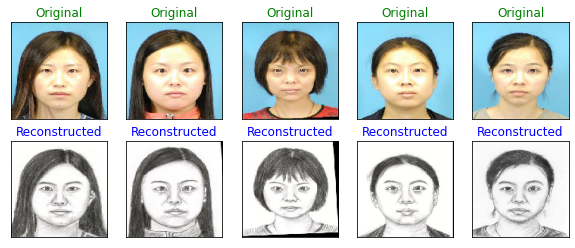

time: 1.75 s (started: 2023-03-04 21:24:14 +00:00)


In [4]:
from sklearn.model_selection import train_test_split

print('Image target size:', TARGET_SIZE)
print('Image dimensions:', IMG_DIM)


CUHK_DATASET = '/content/FaceSketchSynthesis/datasets/cuhk_dataset'
cuhk_photos = preparation.load_dataset(CUHK_DATASET+'/photos', TARGET_SIZE)
cuhk_sketches = preparation.load_dataset(CUHK_DATASET+'/sketches', TARGET_SIZE)

cuhk_photo_train, cuhk_photo_test, cuhk_sketch_train, cuhk_sketch_test = train_test_split(
    cuhk_photos, cuhk_sketches, test_size=0.10, shuffle=True)


print('\nDataset size is', cuhk_photos.shape)
train_size = cuhk_photo_train.shape[0]
test_size = cuhk_photo_test.shape[0]
print('Training size:', train_size)
print('Test size:', test_size)

preparation.plot_side_by_side(cuhk_photos, cuhk_sketches, TARGET_SIZE, n=5)

# Architectures

We present a model in two phases:
- A fully trained autoencoder that learns the encoding of a sketch
- A larger network, ***TransferAE***, that is comprised of convolutional layers and the decoder of an autoencoder.

In [7]:
class Autoencoder(Model):
  def __init__(self, encoder, decoder, latent_size=None,**kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.latent_dim = latent_size if latent_size else tuple(self.encoder.layers[-1].output.shape[1:])

  def call(self, inputs):
    return self.decoder(self.encoder(inputs))


def get_autoencoder(model_name:str = 'autoencoder'):
    # Inputs

    input_img = layers.Input(shape=IMG_DIM, name='input_image')

    # Encoder
    x = base_models.convolutionStack(input_img, 32, activation=layers.LeakyReLU(0.2), 
                                    kernel_size=3, use_bn=False, strides=2)
    x = base_models.convolutionStack(x, 32, activation=layers.LeakyReLU(0.2), 
                                    kernel_size=3, use_bn=False, strides=1)
    latent_inputs = base_models.convolutionStack(x, 16, activation=layers.LeakyReLU(0.2), 
                                    kernel_size=3, strides=2)
    encoder = Model(input_img, latent_inputs)

    latent_inputs_shape = latent_inputs.shape[1:]

    # Decoder
    latent_x = layers.Input(shape=latent_inputs_shape)
    x = layers.UpSampling2D(size=2, interpolation='bilinear')(latent_x)
    x = base_models.convolutionStack(x, 32, activation=layers.LeakyReLU(0.2), 
                                    kernel_size=3, use_bn=False, strides=1)
    x = base_models.convolutionStack(x, 16, activation=layers.LeakyReLU(0.2), 
                                    kernel_size=3, use_bn=True, strides=1)
    x = layers.UpSampling2D(size=2, interpolation='lanczos5')(x)
    x = layers.Conv2D(3, kernel_size=3, strides=1, padding='same', 
                      activation='sigmoid', name='decoded_output')(x)
    decoder = Model(latent_x, x)
    # autoencoder = Model(input_img, x, name=model_name)
    autoencoder = Autoencoder(encoder,decoder)

    return autoencoder

time: 7.77 ms (started: 2023-03-04 21:26:18 +00:00)


# Sketch Reconstruction 

We train an autoencoder on the task of sketch reconstruction, first. Alternatively, we can recover it directly from the models paths.

### Model Training

In [8]:
model2_sk = get_autoencoder('model2_sketch_ae')

model2_sk.compile(
    optimizer = keras.optimizers.Adam(0.005),
    loss = keras.losses.binary_crossentropy
)

time: 2 s (started: 2023-03-04 21:26:30 +00:00)


In [9]:
model2_sk.fit(cuhk_sketch_train, cuhk_sketch_train,
                 epochs=100, batch_size=32, 
                 validation_split=0.15)

model2_sk.save(f'{MODELS_PATH}model2_s2s')

Epoch 1/100
5/5 [==============================] - 7s 908ms/step - loss: 0.5419 - val_loss: 0.9295
Epoch 2/100
5/5 [==============================] - 4s 845ms/step - loss: 0.3391 - val_loss: 1.5312
Epoch 3/100
5/5 [==============================] - 5s 1s/step - loss: 0.2811 - val_loss: 1.7222
Epoch 4/100
5/5 [==============================] - 4s 849ms/step - loss: 0.2693 - val_loss: 1.9268
Epoch 5/100
5/5 [==============================] - 4s 843ms/step - loss: 0.2676 - val_loss: 1.5004
Epoch 6/100
5/5 [==============================] - 5s 913ms/step - loss: 0.2700 - val_loss: 1.7448
Epoch 7/100
5/5 [==============================] - 4s 848ms/step - loss: 0.2698 - val_loss: 2.3647
Epoch 8/100
5/5 [==============================] - 5s 1s/step - loss: 0.2639 - val_loss: 2.6654
Epoch 9/100
5/5 [==============================] - 4s 841ms/step - loss: 0.2612 - val_loss: 1.6744
Epoch 10/100
5/5 [==============================] - 4s 853ms/step - loss: 0.2589 - val_loss: 1.6849
Epoch 11/100
5/

time: 7min 49s (started: 2023-03-04 21:26:41 +00:00)


### Model Recovery

In [ ]:
model2_sk = keras.models.load_model(f'{MODELS_PATH}model2_s2s')
model2_sk.build((None, *IMG_DIM))
model2_sk.summary()

### Model Testing and evaluation

1/1 [==============================] - 0s 318ms/step


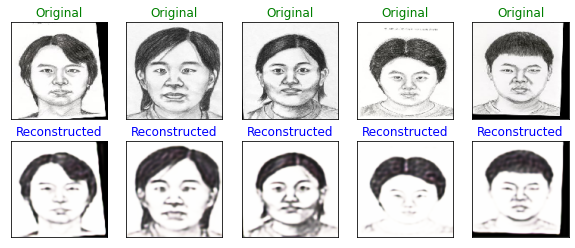

time: 999 ms (started: 2023-03-04 21:36:37 +00:00)


In [10]:
reconstructed_sketches = model2_sk.predict(cuhk_sketch_test)
preparation.plot_side_by_side(cuhk_sketch_test, reconstructed_sketches, TARGET_SIZE)

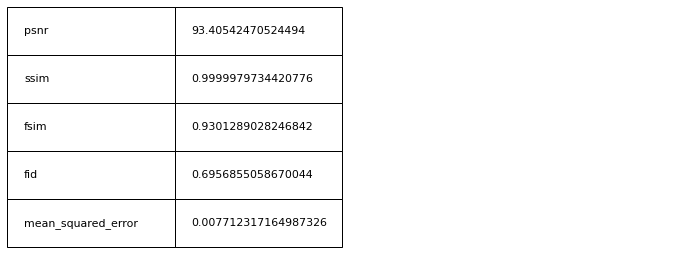

time: 254 ms (started: 2023-03-04 21:37:48 +00:00)


In [12]:
evaluator_sk = similarity.Evaluator('sketch_reconstruction')
for measure_name in similarity.PRE_LOADED_MEASURES:
  evaluator_sk.evaluate_batch(cuhk_sketch_test,reconstructed_sketches, measure_name)
evaluator_sk.results
preparation.plot_results(evaluator_sk.results)


# Transfer Learning

We build a convolutional network on top of the already trained decoder of the autoencoder.

In [14]:
# We begin with a trained autoencoder for sketch reconstruction
# Either fetch from section above or load it 
# sketch_autoencoder = keras.models.load_model(f'{MODELS_PATH}model2_s2s')
sketch_autoencoder = model2_sk

# Freeze the model
sketch_autoencoder.trainable = False

input_img = layers.Input(shape=IMG_DIM, name='input_image')

# Encode the image to a latent code for a sketch
x = base_models.convolutionStack(input_img, 32, activation=layers.LeakyReLU(0.2), 
                                kernel_size=3, use_bn=False, strides=2)
x = base_models.convolutionStack(x, 32, activation=layers.LeakyReLU(0.2), 
                                kernel_size=3, use_bn=False, strides=1)
x = base_models.convolutionStack(x, 16, activation=layers.LeakyReLU(0.1), kernel_size=3)
latent_inputs = base_models.convolutionStack(x, 16, activation=layers.LeakyReLU(0.2), 
                                kernel_size=3, strides=2)

# Now decode the representation to a sketch
output_img = sketch_autoencoder.decoder(latent_inputs)

# Define the transferae and an evaluator object
transfer_ae = Model(input_img, output_img, name='model2_transfer_f2s')
transfer_ae_eval = similarity.Evaluator('model_transfer_f2s')

transfer_ae.compile(
    keras.optimizers.Adam(0.003),
    keras.losses.binary_crossentropy
)

transfer_ae.summary()

Model: "model2_transfer_f2s"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 16)        4624      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 64, 64, 16)

## Initial Model Training

Initially, we train the new model for 100 epochs, with the decoder frozen. We only effectively train the new layers

Epoch 1/100
6/6 [==============================] - 6s 807ms/step - loss: 0.7089 - val_loss: 0.5939
Epoch 2/100
6/6 [==============================] - 8s 1s/step - loss: 0.4700 - val_loss: 0.4536
Epoch 3/100
6/6 [==============================] - 4s 707ms/step - loss: 0.4156 - val_loss: 0.4244
Epoch 4/100
6/6 [==============================] - 5s 851ms/step - loss: 0.3974 - val_loss: 0.4226
Epoch 5/100
6/6 [==============================] - 5s 724ms/step - loss: 0.3927 - val_loss: 0.4202
Epoch 6/100
6/6 [==============================] - 4s 709ms/step - loss: 0.3886 - val_loss: 0.4232
Epoch 7/100
6/6 [==============================] - 5s 934ms/step - loss: 0.3889 - val_loss: 0.4185
Epoch 8/100
6/6 [==============================] - 4s 709ms/step - loss: 0.3859 - val_loss: 0.4221
Epoch 9/100
6/6 [==============================] - 4s 719ms/step - loss: 0.3853 - val_loss: 0.4166
Epoch 10/100
6/6 [==============================] - 5s 804ms/step - loss: 0.3835 - val_loss: 0.4162
Epoch 11/100

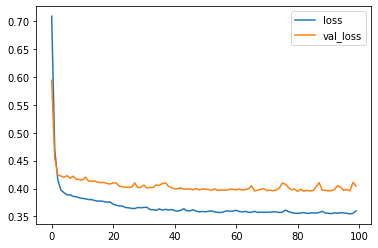

time: 7min 59s (started: 2023-03-04 21:38:35 +00:00)


In [15]:
transfer_ae.fit(
    cuhk_photo_train, cuhk_sketch_train,
    batch_size=32, epochs=100, 
    validation_data=(cuhk_photo_test, cuhk_sketch_test)
)

plt.plot(transfer_ae.history.history["loss"])
plt.plot(transfer_ae.history.history["val_loss"])
plt.legend(['loss', 'val_loss'], loc='upper right')


1/1 [==============================] - 0s 185ms/step


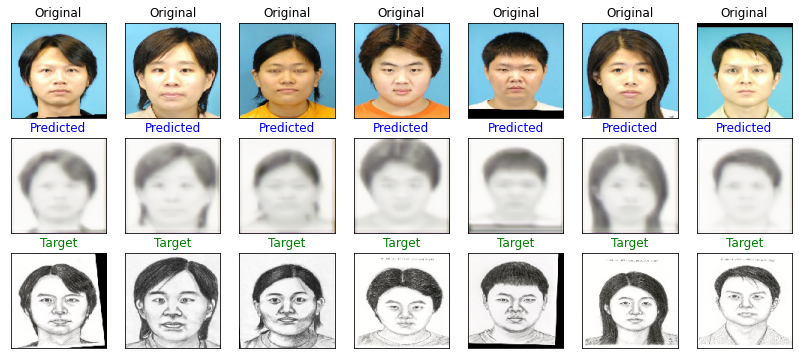

Mean FID over the test samples: 10.34973430633545
time: 1.59 s (started: 2023-03-04 21:51:58 +00:00)


In [17]:
generated_sketches = transfer_ae.predict(cuhk_photo_test)
preparation.plot_synthesis(cuhk_photo_test, generated_sketches, cuhk_sketch_test, TARGET_SIZE, n=7)

# Evaluate with the FID index
fid_index = transfer_ae_eval.evaluate_batch(cuhk_photo_test, generated_sketches, 'fid')
print('Mean FID over the test samples:', fid_index)

## Fine Tuning the model

The final step is **fine-tuning** the model. It consists of unfreezing part of (or all) the layers and retrain the model on a very low learning rate.

Epoch 1/10
5/5 [==============================] - 14s 2s/step - loss: 0.5145 - val_loss: 0.3143
Epoch 2/10
5/5 [==============================] - 7s 1s/step - loss: 0.5063 - val_loss: 0.3151
Epoch 3/10
5/5 [==============================] - 5s 979ms/step - loss: 0.4997 - val_loss: 0.3172
Epoch 4/10
5/5 [==============================] - 5s 1s/step - loss: 0.4946 - val_loss: 0.3200
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.4870 - val_loss: 0.3232
Epoch 6/10
5/5 [==============================] - 5s 965ms/step - loss: 0.4816 - val_loss: 0.3266
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.4768 - val_loss: 0.3300
Epoch 8/10
5/5 [==============================] - 5s 980ms/step - loss: 0.4717 - val_loss: 0.3333
Epoch 9/10
5/5 [==============================] - 7s 1s/step - loss: 0.4671 - val_loss: 0.3365
Epoch 10/10
5/5 [==============================] - 6s 999ms/step - loss: 0.4624 - val_loss: 0.3394


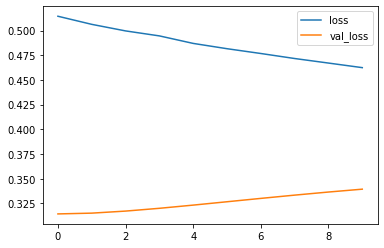

time: 1min 24s (started: 2023-03-04 21:52:25 +00:00)


In [18]:
# Unfreeze all layers
transfer_ae.trainable = True

transfer_ae.compile(
    keras.optimizers.Adam(0.00001),
    keras.losses.binary_crossentropy
)
transfer_ae.fit(
    cuhk_photo_train, cuhk_sketch_train,
    batch_size=32, epochs=10, validation_split=0.05
)

plt.plot(transfer_ae.history.history["loss"])
plt.plot(transfer_ae.history.history["val_loss"])
plt.legend(['loss', 'val_loss'], loc='upper right')

1/1 [==============================] - 0s 280ms/step


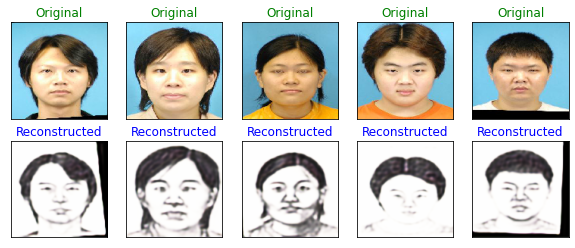

time: 941 ms (started: 2023-03-04 21:56:23 +00:00)


In [19]:
generated_sketches = transfer_ae.predict(cuhk_photo_test)
preparation.plot_side_by_side(cuhk_photo_test, reconstructed_sketches, TARGET_SIZE)

# Model Evaluation

/usr/local/lib/python3.8/dist-packages/image_similarity_measures/quality_metrics.py:197: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(org_img, pred_img, data_range=max_p, multichannel=True)


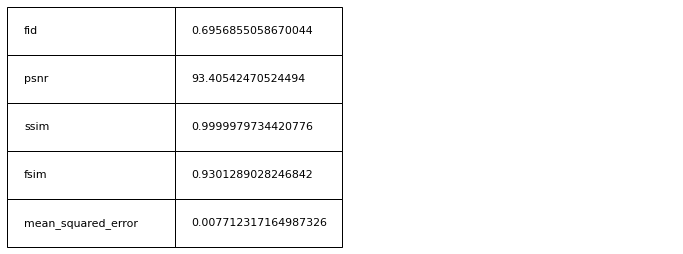

time: 7.38 s (started: 2023-03-04 21:56:49 +00:00)


In [21]:
for measure_name in similarity.PRE_LOADED_MEASURES:
  transfer_ae_eval.evaluate_batch(cuhk_sketch_test,reconstructed_sketches, measure_name)
preparation.plot_results(transfer_ae_eval.results)

In [23]:
transfer_ae.save(f'{MODELS_PATH}model2_transferf2s')

time: 2.17 s (started: 2023-03-04 21:59:43 +00:00)
